# California Housing Price Prediction App

* Sandikha Rahardi (Kuldii Project)
* https://kuldiiproject.com

This notebook predicts housing prices in California using the California housing dataset from scikit-learn. The application is built with Gradio to enable feature input and house price prediction. It also includes various data visualizations and location-based clustering using KMeans on Longitude and Latitude data.

## 1. Import Libraries

Import all the necessary libraries for data processing, modeling, visualization, and building the Gradio-based application.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import joblib
import numpy as np
import gradio as gr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## 2. Load and Explore Dataset

Load the dataset, convert it to a DataFrame, and display basic information.

In [2]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MedHouseVal'] = data.target
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [3]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### Feature Explanation and Recommended Treatments

| Feature       | Data Type | Brief Description                        | Recommended Treatment                                       |
| ------------- | --------- | ---------------------------------------- | ----------------------------------------------------------- |
| `MedInc`      | Numeric   | Median income                            | Standardization or normalization                            |
| `HouseAge`    | Numeric   | Age of the house                         | Standardization; check and handle outliers if necessary     |
| `AveRooms`    | Numeric   | Average number of rooms per household    | Remove extreme outliers; then standardize                   |
| `AveBedrms`   | Numeric   | Average number of bedrooms               | Remove extreme outliers; then standardize                   |
| `Population`  | Numeric   | Area population                          | Remove extreme outliers; optional log transformation        |
| `AveOccup`    | Numeric   | Average occupancy per household          | Remove extreme outliers; then standardize                   |
| `Latitude`    | Numeric   | Geographical coordinate (latitude)       | Used for location-based clustering; not used directly       |
| `Longitude`   | Numeric   | Geographical coordinate (longitude)      | Used for location-based clustering; not used directly       |
| `Region`      | Categorical | Clustered region based on coordinates    | One-hot encoded; used as a categorical feature              |


## 3. Preprocess Data (Standardization)
Standardize the feature columns using StandardScaler. Handle missing values if present.

In [5]:
# Check null values
df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [6]:
# Numeric features (excluding Region, Latitude, and Longitude)
numeric_features = [f for f in data.feature_names if f not in ['Latitude', 'Longitude']]

# Categorical features
categorical_features = ['Region']

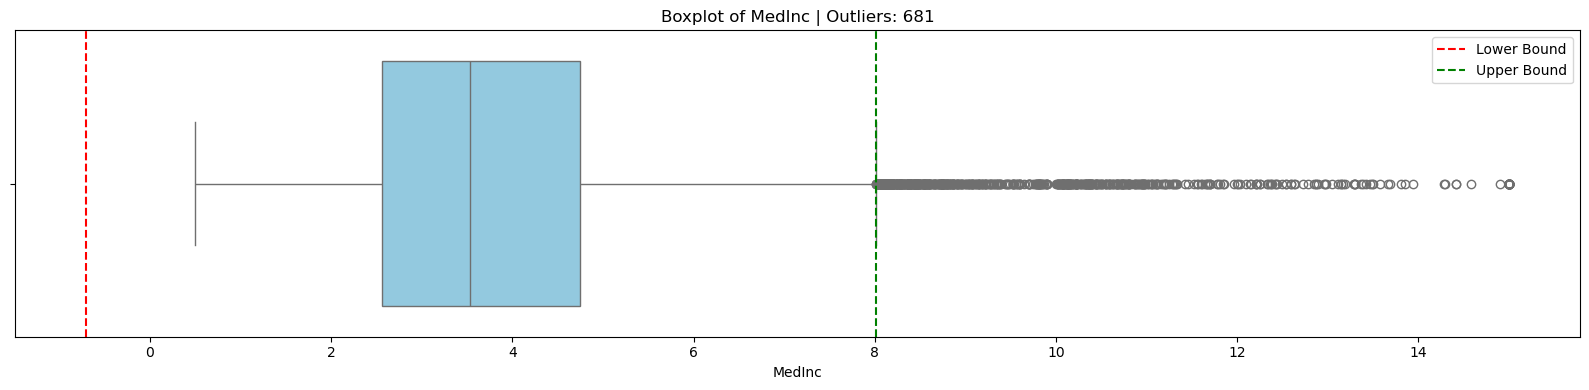


[INFO] Feature: MedInc
IQR = 2.18
Lower Bound = -0.71
Upper Bound = 8.01
Number of outliers = 681



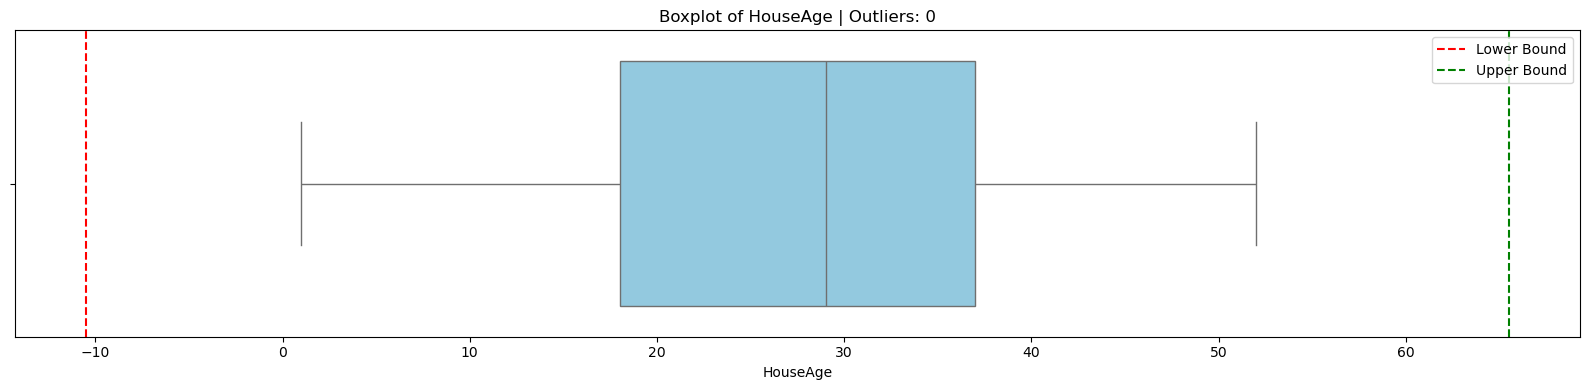


[INFO] Feature: HouseAge
IQR = 19.00
Lower Bound = -10.50
Upper Bound = 65.50
Number of outliers = 0



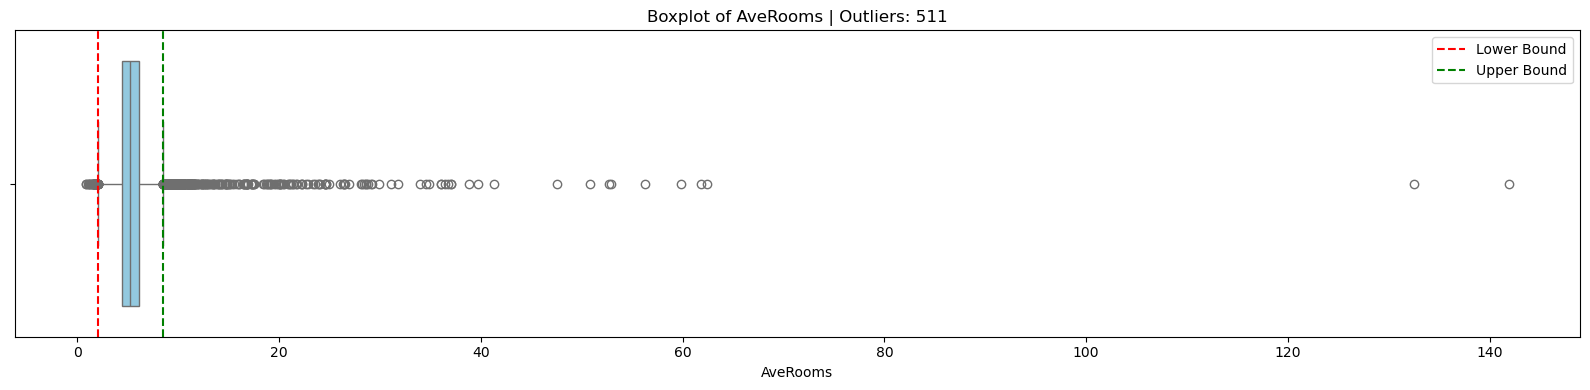


[INFO] Feature: AveRooms
IQR = 1.61
Lower Bound = 2.02
Upper Bound = 8.47
Number of outliers = 511



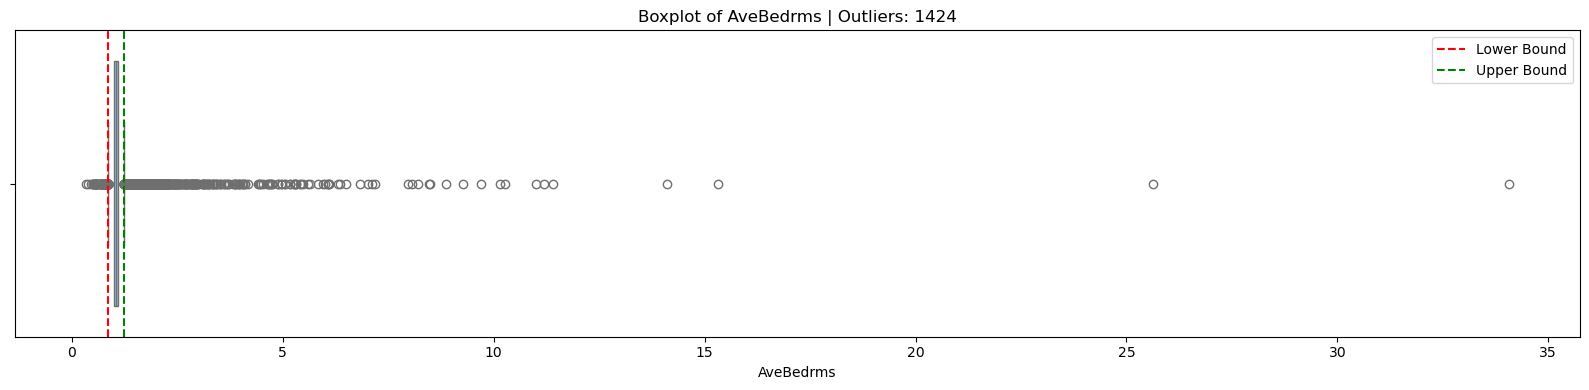


[INFO] Feature: AveBedrms
IQR = 0.09
Lower Bound = 0.87
Upper Bound = 1.24
Number of outliers = 1424



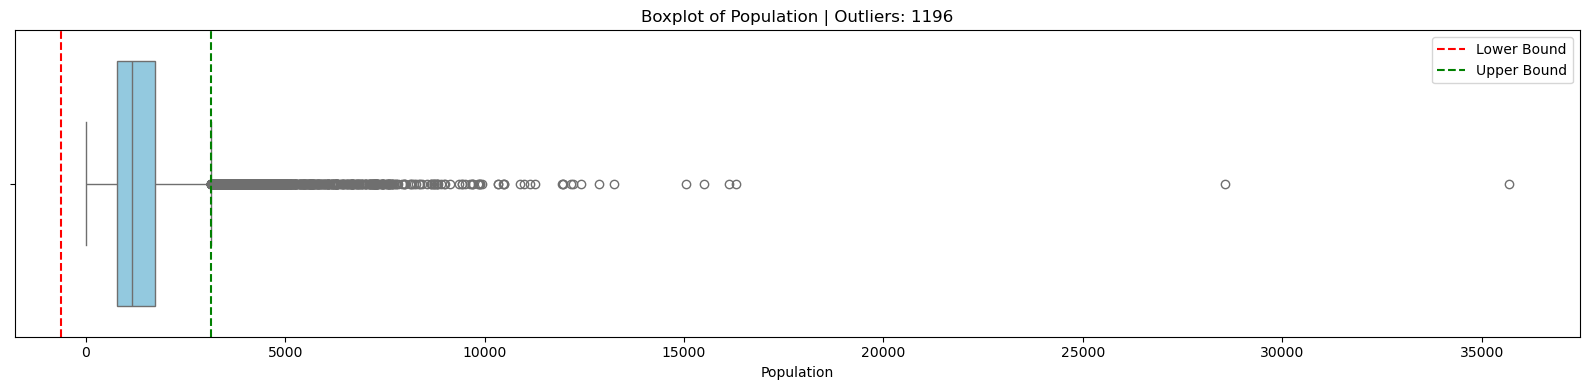


[INFO] Feature: Population
IQR = 938.00
Lower Bound = -620.00
Upper Bound = 3132.00
Number of outliers = 1196



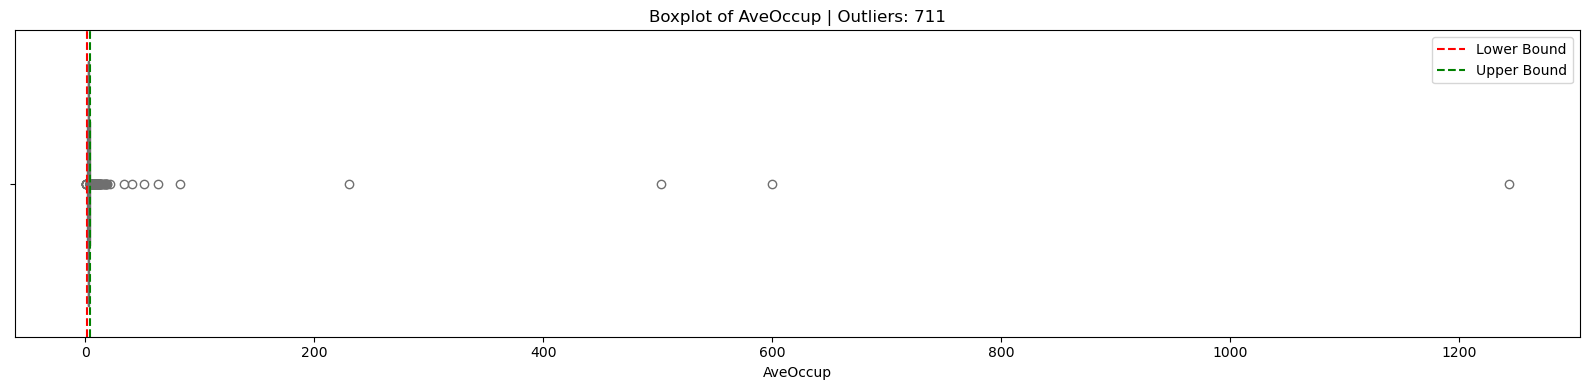


[INFO] Feature: AveOccup
IQR = 0.85
Lower Bound = 1.15
Upper Bound = 4.56
Number of outliers = 711



In [7]:
def check_outliers(df, feature):
    # Calculate basic statistics
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]

    # Visualize with boxplot
    plt.figure(figsize=(16, 4))
    sns.boxplot(x=df[feature], color='skyblue')
    plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
    plt.title(f'Boxplot of {feature} | Outliers: {len(outliers)}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print outlier summary
    print(f"\n[INFO] Feature: {feature}")
    print(f"IQR = {iqr:.2f}")
    print(f"Lower Bound = {lower_bound:.2f}")
    print(f"Upper Bound = {upper_bound:.2f}")
    print(f"Number of outliers = {len(outliers)}\n")

# Example usage:
for feature in numeric_features:
    check_outliers(df, feature)

In [8]:
# Remove rows with outliers based on predefined thresholds
# Remove AveRooms > 80
# Remove AveBedrms > 15
# Remove Population > 15000
# Remove AveOccup > 20

# Threshold rules for each feature
thresholds = {
    'AveRooms': 80,
    'AveBedrms': 15,
    'Population': 15000,
    'AveOccup': 20
}

# Print number of rows before cleaning
print(f"Number of rows before cleaning: {len(df)}")

# Iterate through each rule and remove outliers
for feature, max_value in thresholds.items():
    original_len = len(df)
    df = df[df[feature] <= max_value]
    print(f"{feature}: Removed {original_len - len(df)} rows (>{max_value})")

# Print number of rows after cleaning
print(f"\nNumber of rows after cleaning: {len(df)}")

Number of rows before cleaning: 20640
AveRooms: Removed 2 rows (>80)
AveBedrms: Removed 1 rows (>15)
Population: Removed 6 rows (>15000)
AveOccup: Removed 10 rows (>20)

Number of rows after cleaning: 20621


### Clustering Coordinates with KMeans

We create a new feature called `Region` by applying KMeans clustering on the geographical coordinates (`Latitude` and `Longitude`).

- A fixed number of clusters is set (e.g., 10) to represent different regions in California.
- After the `Region` feature is generated, the original `Latitude` and `Longitude` columns are no longer used as model features.

In [9]:
# Add 'Region' feature using KMeans clustering on Latitude and Longitude
N_REGION = 10
coords = df[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=N_REGION, random_state=42, n_init=20)
df['Region'] = kmeans.fit_predict(coords)

# Exclude Latitude and Longitude from features, and include the new 'Region'
features = [f for f in data.feature_names if f not in ['Latitude', 'Longitude']] + ['Region']

### Clustering Region Visualization Based on Longitude and Latitude

This visualization shows the result of KMeans clustering on the map of Longitude vs. Latitude. Each color represents a different region (cluster) identified by KMeans.

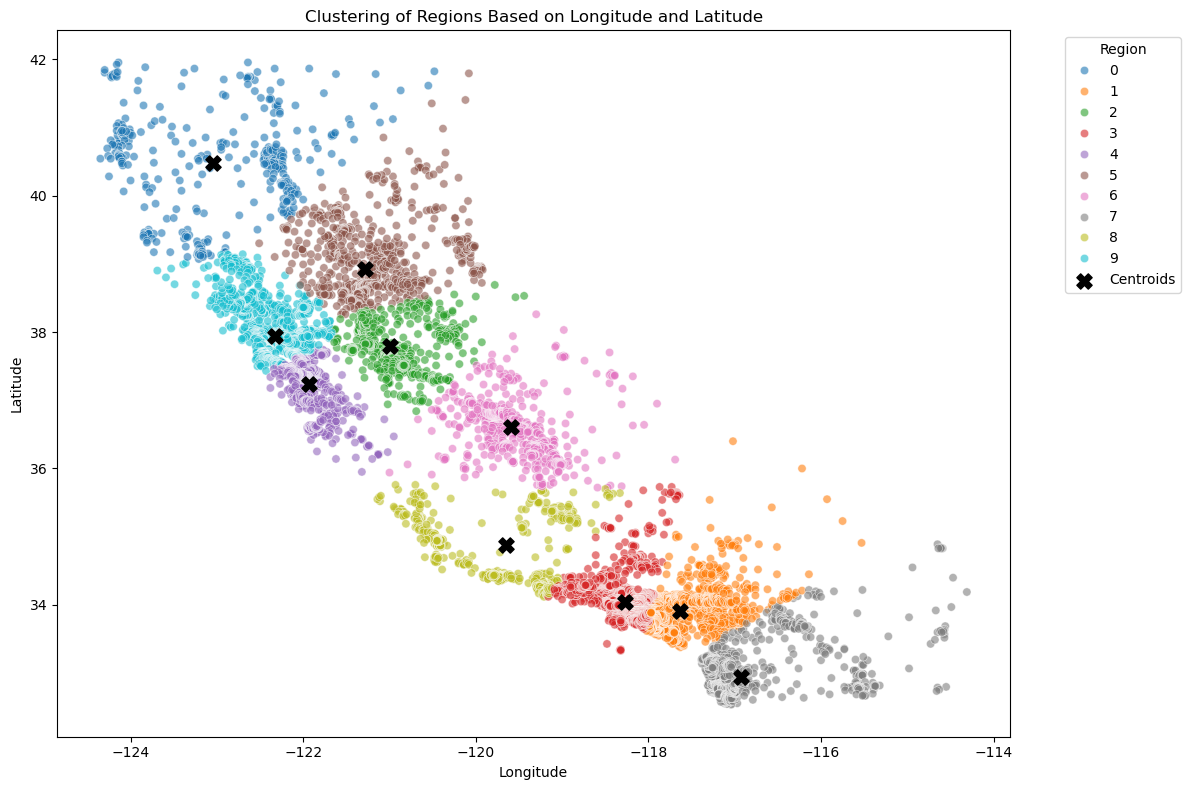

In [10]:
# Visualize region clustering on Longitude vs Latitude map
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=df['Longitude'], y=df['Latitude'], hue=df['Region'],
    palette='tab10', legend='full', alpha=0.6
)
# Plot cluster centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 1], centroids[:, 0], c='black', s=120, marker='X', label='Centroids')
plt.title('Clustering of Regions Based on Longitude and Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Additional Visual Analysis

The following visualizations help us better understand the data distribution and the relationship between key features and house prices.

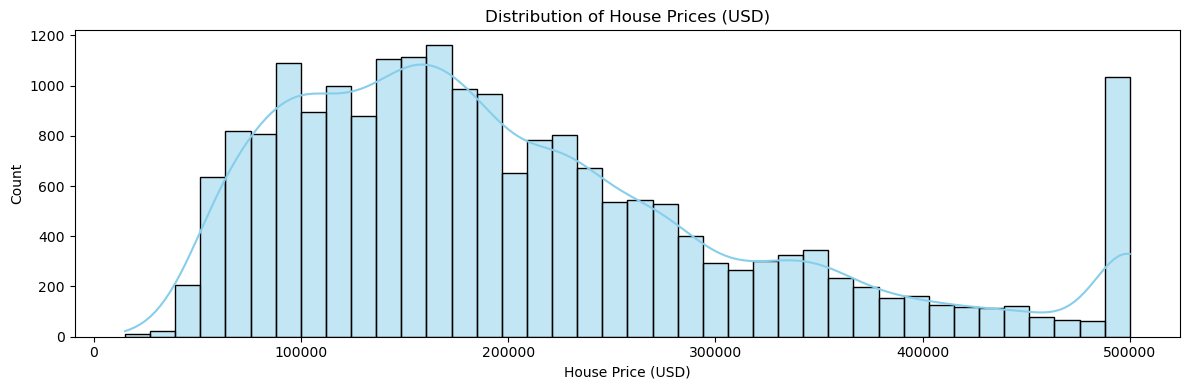

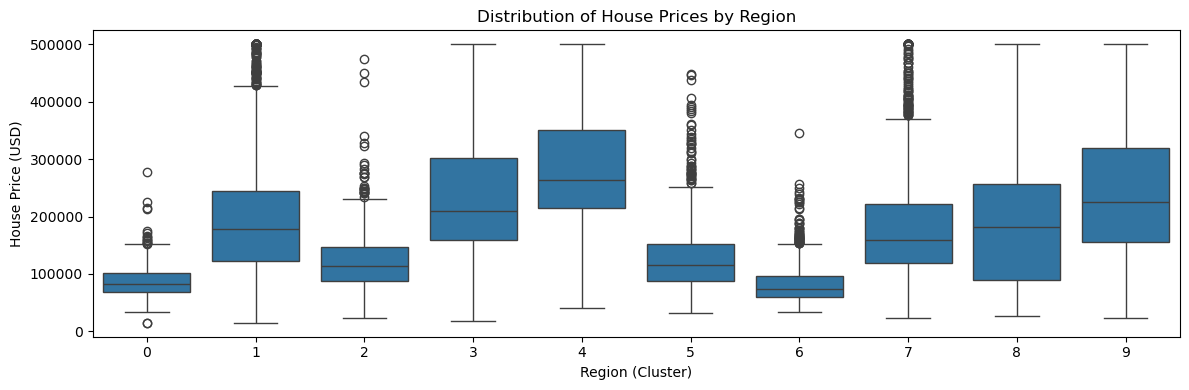

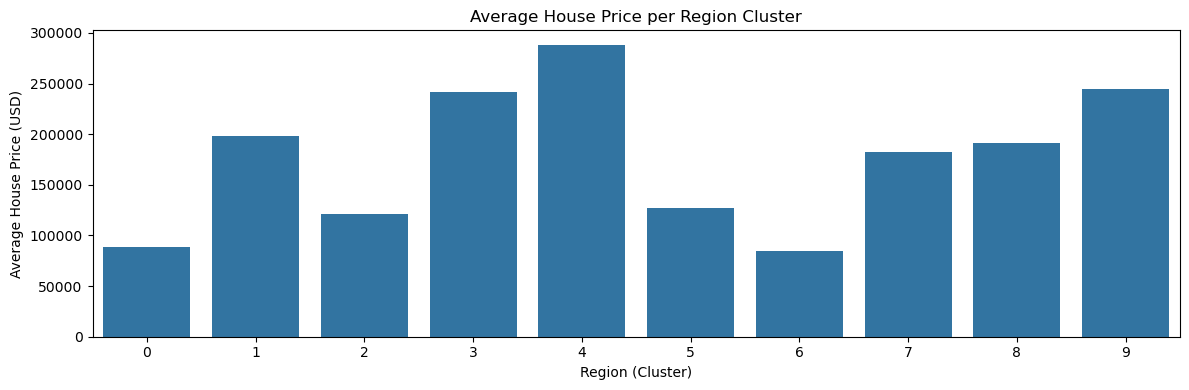

In [11]:
# Distribution of house prices (histogram)
plt.figure(figsize=(12, 4))
sns.histplot(df['MedHouseVal'] * 100000, bins=40, kde=True, color='skyblue')
plt.title('Distribution of House Prices (USD)')
plt.xlabel('House Price (USD)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Boxplot of house prices by region
plt.figure(figsize=(12, 4))
sns.boxplot(x=df['Region'], y=df['MedHouseVal'] * 100000)
plt.title('Distribution of House Prices by Region')
plt.xlabel('Region (Cluster)')
plt.ylabel('House Price (USD)')
plt.tight_layout()
plt.show()

# Average house price per region (bar chart)
plt.figure(figsize=(12, 4))
mean_prices = df.groupby('Region')['MedHouseVal'].mean() * 100000
sns.barplot(x=mean_prices.index, y=mean_prices.values)
plt.title('Average House Price per Region Cluster')
plt.xlabel('Region (Cluster)')
plt.ylabel('Average House Price (USD)')
plt.tight_layout()
plt.show()

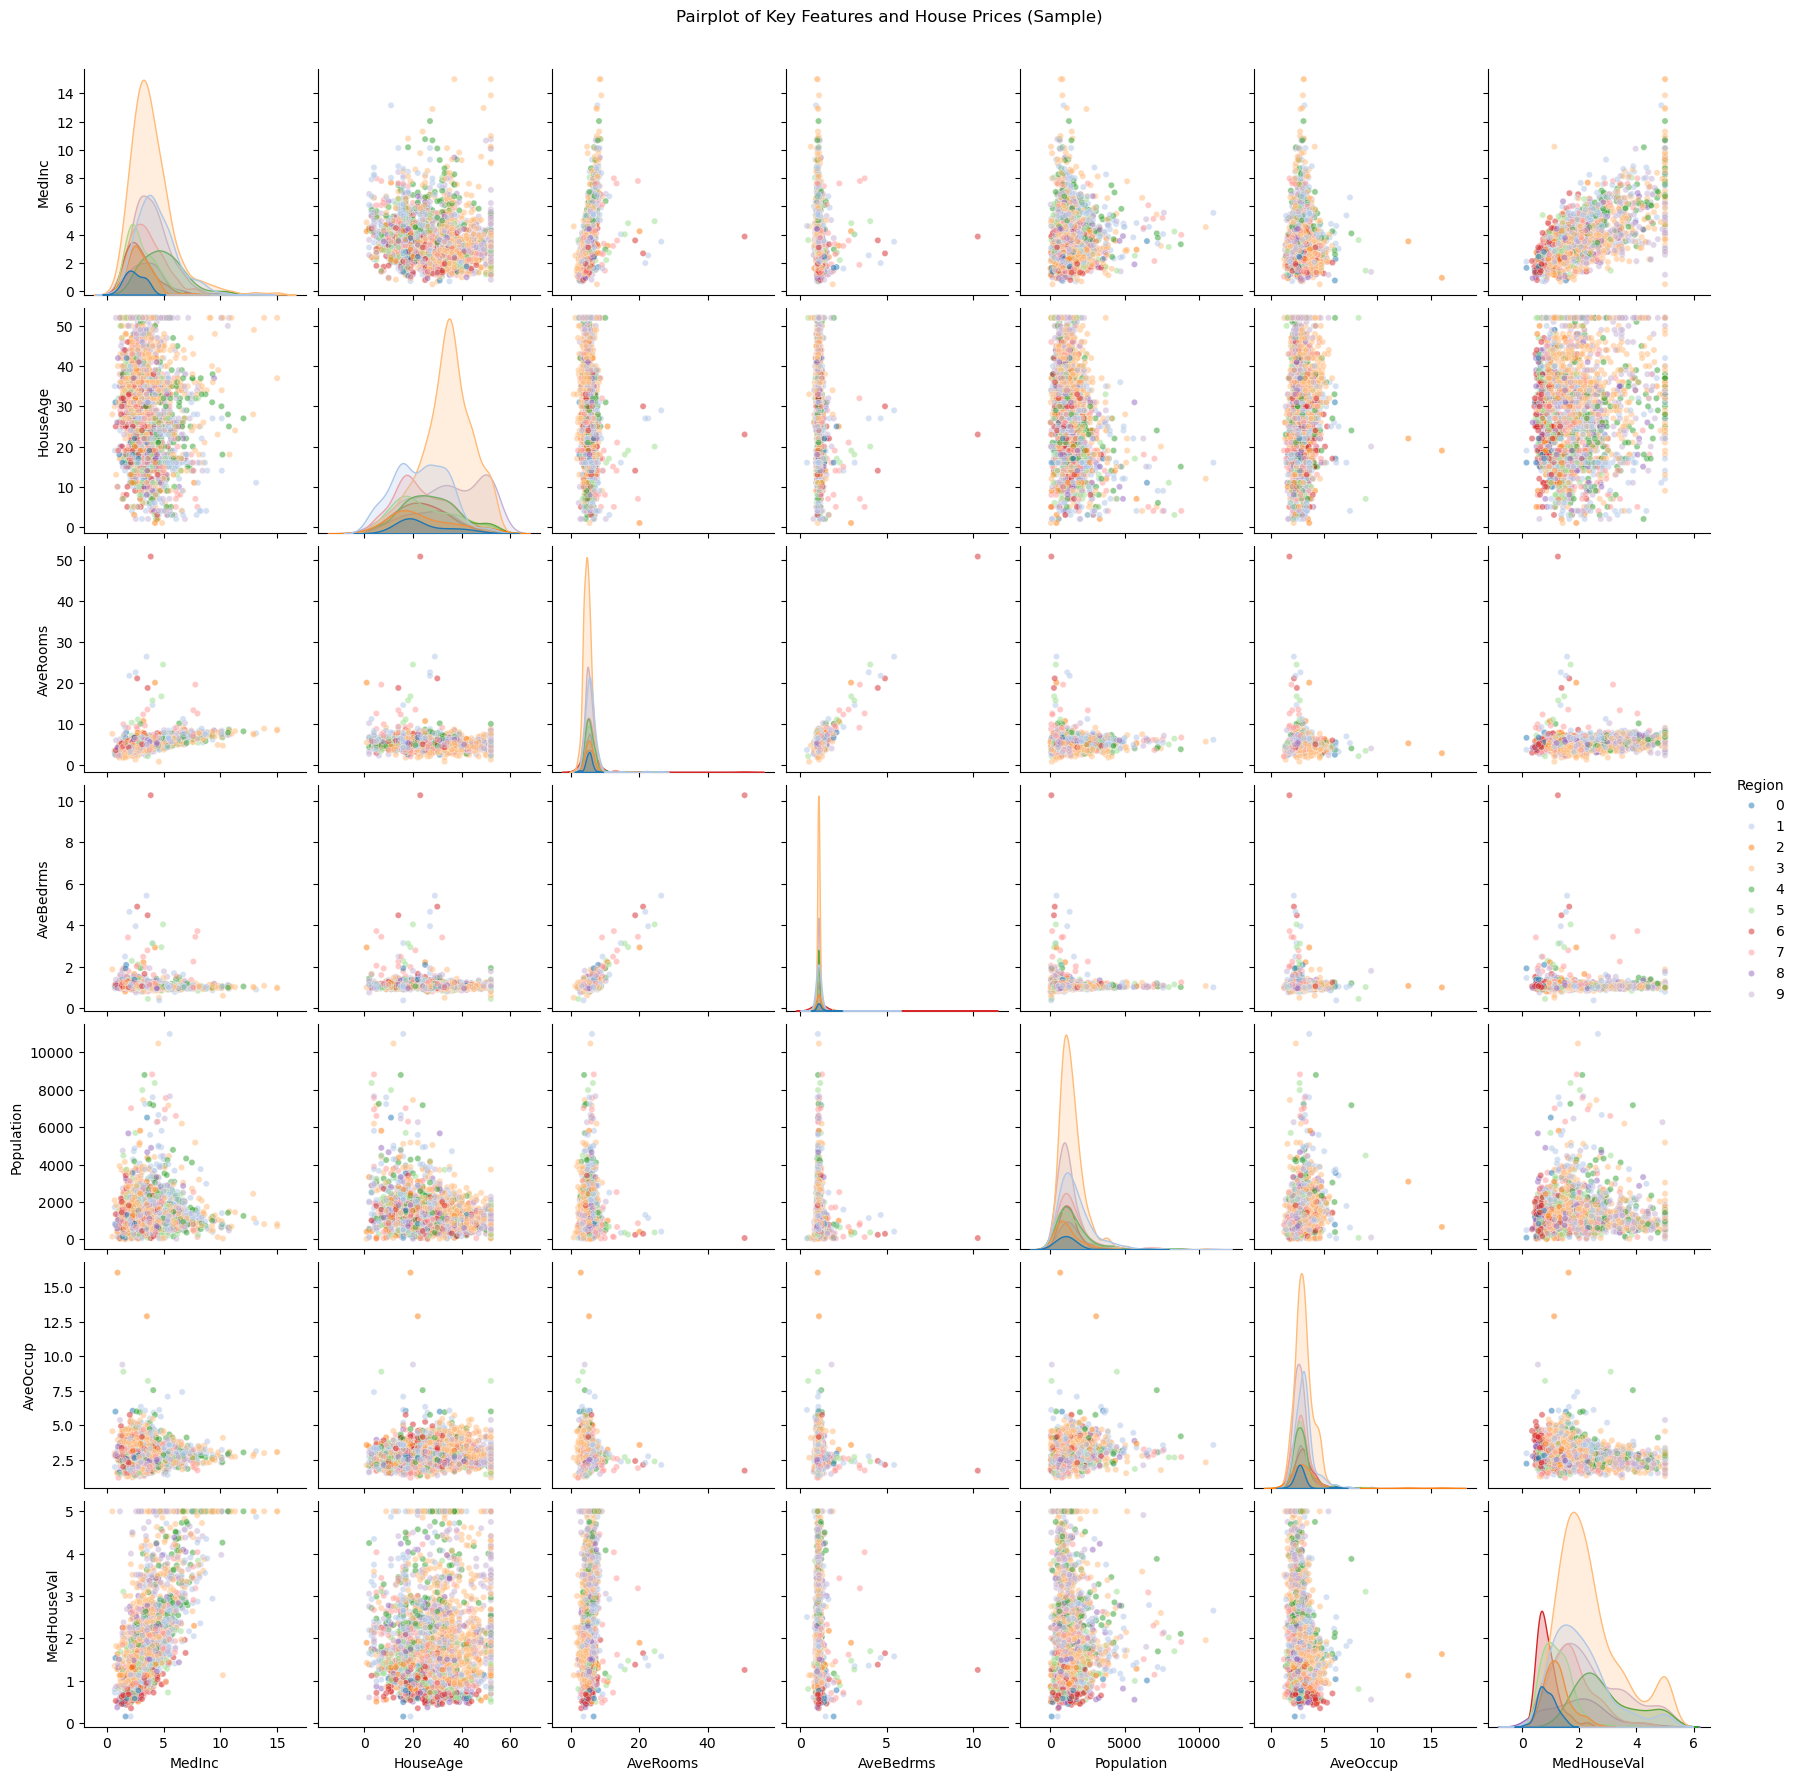

In [12]:
# Pairplot of key features vs house price, colored by region (with sampling)
sample_df = df.sample(n=2000, random_state=42) if len(df) > 2000 else df
sns.pairplot(
    sample_df,
    vars=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'MedHouseVal'],
    hue='Region',
    palette='tab20',
    plot_kws={'alpha': 0.5, 's': 20}
)
plt.suptitle('Pairplot of Key Features and House Prices (Sample)', y=1.02)
plt.show()

## 4. Split Data into Train and Test Sets

Split the dataset into training and testing subsets using `train_test_split`. The `Region` feature is included among the predictors.

In [13]:
# Split data into training and testing sets
X = df[features]  # Includes 'Region'
y = df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [14]:
X_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Region
17219,7.7261,32.0,7.068311,1.079696,1304.0,2.474383,8
17829,6.5226,21.0,5.392996,1.011673,946.0,3.680934,4
8357,3.8512,47.0,5.280112,1.011204,954.0,2.672269,3
4822,2.1162,35.0,3.622744,1.030686,1513.0,2.731047,3
10045,4.0426,15.0,6.884804,1.102941,1267.0,3.105392,5
...,...,...,...,...,...,...,...
11294,4.5739,35.0,6.010101,0.969697,1033.0,3.478114,1
11975,4.5660,18.0,7.236324,1.196937,1738.0,3.803063,1
5393,2.7670,42.0,4.735602,1.109948,1094.0,2.863874,3
860,5.7192,15.0,6.395349,1.067979,1777.0,3.178891,4


## 5. Train Regression Models

Train and evaluate multiple regression models using a pipeline that includes preprocessing and optional hyperparameter tuning via GridSearchCV.

We define several models—Linear Regression, Random Forest, Gradient Boosting, and Support Vector Regression—along with their respective hyperparameter grids. Each model is trained using a unified pipeline that handles both numeric and categorical preprocessing. Grid search is applied for models that have tuning parameters defined.

The results are printed and stored for comparison.

In [15]:
# 1. Define regression models and their hyperparameters
regressor_configs = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}  # No hyperparameter tuning
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [None, 10, 20]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100],
            'regressor__learning_rate': [0.1, 0.05]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'regressor__C': [1.0, 10.0],
            'regressor__kernel': ['rbf', 'linear']
        }
    }
}

# 2. Define preprocessing pipelines
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# 3. Loop through each model, train, and evaluate
results = {}
for name, config in regressor_configs.items():
    print(f"\n🔍 Training model: {name}")
    
    # Create full pipeline: preprocessing + regression model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])
    
    # Apply GridSearchCV if hyperparameters are defined
    if config['params']:
        search = GridSearchCV(pipeline, config['params'], cv=3, scoring='r2', n_jobs=-1)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_score = search.best_score_
        print(f"✅ Best CV R² score for {name}: {best_score:.4f}")
        print(f"Best parameters: {search.best_params_}")
    else:
        pipeline.fit(X_train, y_train)
        best_model = pipeline
        best_score = best_model.score(X_test, y_test)
        print(f"✅ Test R² score for {name}: {best_score:.4f} (no tuning)")
    
    # Store model and score
    results[name] = {
        'model': best_model,
        'r2_score': best_score
    }


🔍 Training model: LinearRegression
✅ Test R² score for LinearRegression: 0.6228 (no tuning)

🔍 Training model: RandomForest
✅ Best CV R² score for RandomForest: 0.7311
Best parameters: {'regressor__max_depth': 20, 'regressor__n_estimators': 100}

🔍 Training model: GradientBoosting
✅ Best CV R² score for GradientBoosting: 0.7285
Best parameters: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 100}

🔍 Training model: SVR
✅ Best CV R² score for SVR: 0.7513
Best parameters: {'regressor__C': 10.0, 'regressor__kernel': 'rbf'}


## 6. Evaluate Model Performance

We evaluate the performance of each trained regression model on the test set using the following metrics:

- **R² Score**: Indicates how well the predictions approximate the actual values (higher is better).
- **MAE (Mean Absolute Error)**: Measures the average magnitude of the prediction errors.
- **MSE (Mean Squared Error)**: Penalizes larger errors more than MAE.
- **RMSE (Root Mean Squared Error)**: Square root of MSE, with the same unit as the target variable.

These metrics provide a comprehensive view of each model's predictive accuracy and error distribution.


In [16]:
# Evaluate all models and display metrics
for name, result in results.items():
    model = result['model']
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Print evaluation results
    print(f"\n📊 Performance Metrics for {name}:")
    print(f"R² Score : {r2:.4f}")
    print(f"MAE      : {mae:.4f}")
    print(f"MSE      : {mse:.4f}")
    print(f"RMSE     : {rmse:.4f}")


📊 Performance Metrics for LinearRegression:
R² Score : 0.6228
MAE      : 0.5101
MSE      : 0.4995
RMSE     : 0.7067

📊 Performance Metrics for RandomForest:
R² Score : 0.7221
MAE      : 0.4209
MSE      : 0.3680
RMSE     : 0.6066

📊 Performance Metrics for GradientBoosting:
R² Score : 0.7114
MAE      : 0.4354
MSE      : 0.3822
RMSE     : 0.6182

📊 Performance Metrics for SVR:
R² Score : 0.7407
MAE      : 0.3927
MSE      : 0.3434
RMSE     : 0.5860


## 7. Feature Importance Visualization

For tree-based models such as Random Forest and Gradient Boosting, we can extract feature importances to understand which features contribute the most to the prediction.

This analysis helps in model interpretability and can guide future feature selection or engineering.


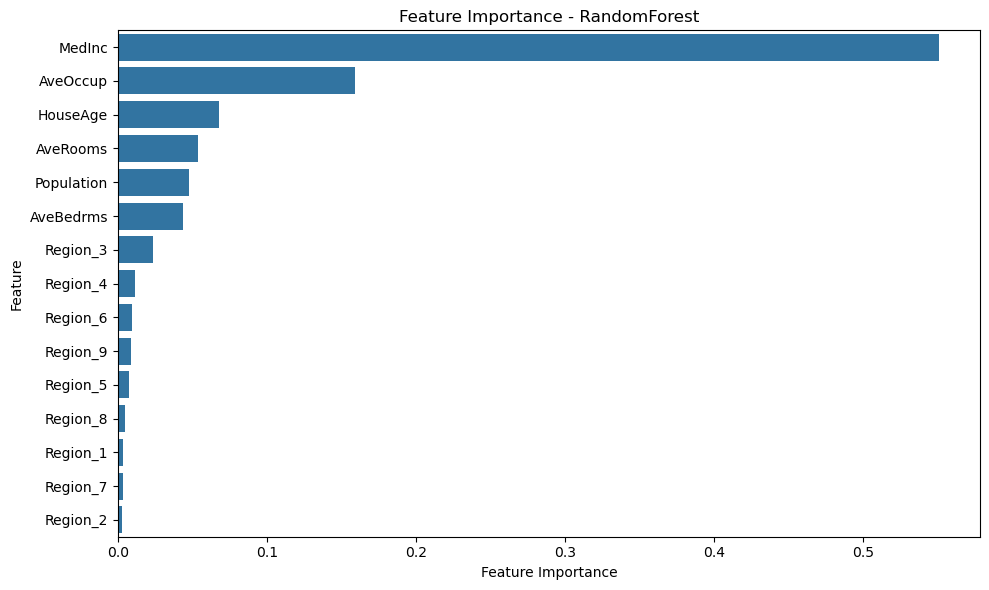

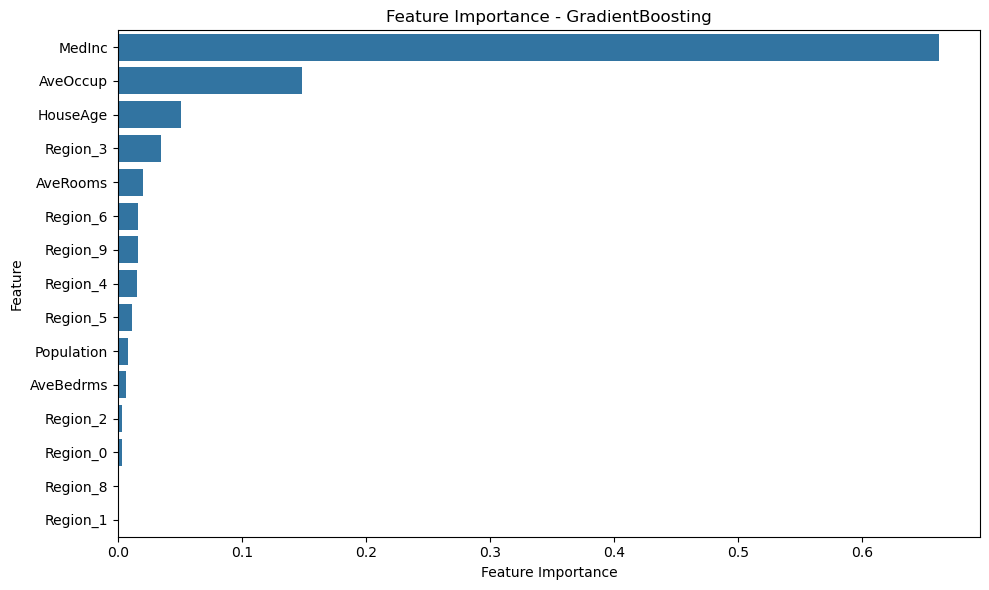

In [17]:
# Function to plot feature importances
def plot_feature_importance(model, feature_names, title):
    # Check if model has feature_importances_ attribute
    if hasattr(model.named_steps['regressor'], 'feature_importances_'):
        importances = model.named_steps['regressor'].feature_importances_
        
        # Get feature names after one-hot encoding
        ohe = model.named_steps['preprocessor'].named_transformers_['cat']
        encoded_cat_features = ohe.get_feature_names_out(categorical_features)
        all_features = numeric_features + list(encoded_cat_features)
        
        # Combine feature names and importances
        feat_imp_df = pd.DataFrame({
            'Feature': all_features,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
        plt.title(title)
        plt.xlabel("Feature Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
    else:
        print(f"❌ The model '{title}' does not support feature importance.")

# Plot feature importances for RandomForest and GradientBoosting only
for name, result in results.items():
    model = result['model']
    if name in ['RandomForest', 'GradientBoosting']:
        plot_feature_importance(model, features, title=f"Feature Importance - {name}")

## 8. Correlation Heatmap Visualization

This heatmap visualizes the correlation matrix of all numerical features in the dataset, including the target variable and any engineered or encoded features such as `Region`.

Correlation values range from -1 to 1:
- Values close to 1 indicate strong positive correlation.
- Values close to -1 indicate strong negative correlation.
- Values near 0 suggest little to no linear correlation.

This analysis is useful for detecting multicollinearity and identifying features with strong relationships to the target variable (`MedHouseVal`).


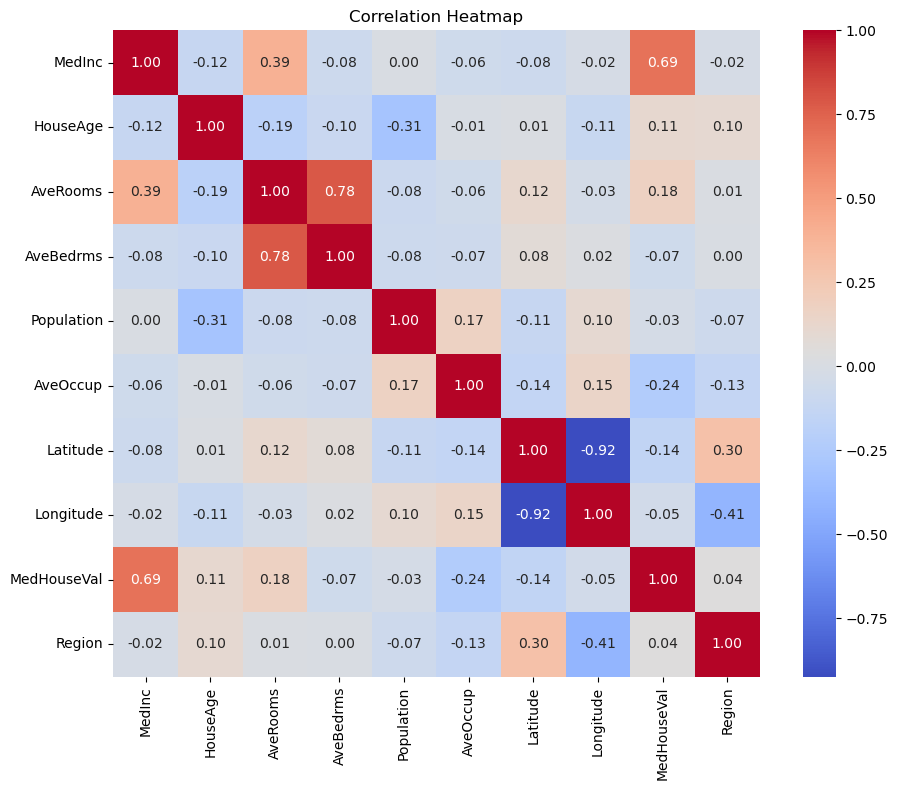

In [18]:
# Compute correlation matrix for all numeric columns
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


## 9. Build Gradio UI for User Input

Create an interactive Gradio interface that allows users to input housing features and select a regression model. Based on the input and selected model, the system will predict the estimated house price.


In [19]:
# Make sure all trained models are stored in `results` from previous steps
def predict_house_price_with_model(model_name, MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude):
    # Predict Region from coordinates
    region = kmeans.predict([[Latitude, Longitude]])[0]

    # Prepare input DataFrame
    input_dict = {
        'MedInc': [MedInc],
        'HouseAge': [HouseAge],
        'AveRooms': [AveRooms],
        'AveBedrms': [AveBedrms],
        'Population': [Population],
        'AveOccup': [AveOccup],
        'Region': [region]
    }
    input_df = pd.DataFrame(input_dict)

    # Get selected model
    model = results[model_name]['model']

    # Predict price
    pred = model.predict(input_df)[0]
    return f"🏠 Estimated House Price (Model: {model_name}, Region: {region}): ${pred * 100000:.2f}"

# Build Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("""
        ## 🏠 California House Price Prediction
        Built with Scikit-learn & Gradio — by Kuldii Project

        This app predicts the estimated house price in California based on property features such as:
        - Median Income
        - House Age
        - Average Rooms & Bedrooms
        - Population & Occupants
        - Latitude & Longitude

        🏷️ **Model Selection**: Choose from different regression models (Random Forest, Linear Regression, etc.)  
        📍 **Region Clustering**: The app automatically assigns a region based on the location (Latitude & Longitude), clustered using KMeans into a total of 10 regions.

        Just fill in the values and click **Predict** to see the estimated price!
    """)

    model_choice = gr.Dropdown(
        choices=list(results.keys()),
        label="Select Regression Model",
        value=list(results.keys())[0]
    )

    with gr.Row():
        MedInc = gr.Slider(minimum=0, maximum=100, value=0, label='Median Income')
        HouseAge = gr.Slider(minimum=0, maximum=100, value=0, label='House Age')

    with gr.Row():
        AveRooms = gr.Slider(minimum=0, maximum=200, value=0, label='Average Rooms')
        AveBedrms = gr.Slider(minimum=0, maximum=50, value=0, label='Average Bedrooms')

    with gr.Row():
        Population = gr.Slider(minimum=0, maximum=15000, value=0, label='Population')
        AveOccup = gr.Slider(minimum=0, maximum=20, value=0, label='Average Occupants')

    with gr.Row():
        Latitude = gr.Slider(minimum=float(df['Latitude'].min()), maximum=float(df['Latitude'].max()), value=float(df['Latitude'].min()), label='Latitude')
        Longitude = gr.Slider(minimum=float(df['Longitude'].min()), maximum=float(df['Longitude'].max()), value=float(df['Longitude'].min()), label='Longitude')

    predict_btn = gr.Button("📈 Predict House Price")
    output = gr.Textbox(label="Prediction Result")

    predict_btn.click(
        fn=predict_house_price_with_model,
        inputs=[model_choice, MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude],
        outputs=output
    )

demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## 10. Saving Models for Deployment

To deploy our California House Price Prediction app, we need to save all the trained models and clustering objects.  

- We save the **entire results dictionary**, which includes different regression models (e.g. Random Forest, Linear Regression, etc.).
- We also save the **KMeans clustering model**, which assigns properties to one of 10 regions based on their latitude and longitude.

Saving these models allows us to load them instantly during deployment, without the need to retrain everything from scratch.


In [21]:
# Save the complete results dictionary containing all trained models
joblib.dump(results, "models/models.pkl")

# Also save the trained KMeans model used for region clustering
joblib.dump(kmeans, "models/kmeans.pkl")


['models/kmeans.pkl']